# Masking tissue region in whole slide images
<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/example_tissuemask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_tissuemask.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

_Please note that if you are selecting Kaggle badge, in the Kaggle notebook you have to login and enable the internet connection from the setting panel on the right in order to install tiatoolbox from the internet._

## About this notebook
This  jupyter notebook can be run on any computer with a standard browser (preferably the latest version of Google Chrome) and no programming language installation is required. It can run be remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on the badge "Open in Colab" above. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on either Github or colab, so you cannot inadvertently mess it up, and you should feel free to experiment. Use the notebook's File Menu if you wish to save your own (changed) notebook.

Before running the notebook outside Colab, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## Welcome to Tiatoolbox
In this example, we will show how you can use tiatoolbox to easily detect the tissue region in whole slide images. Apart from tissue regions, WSIs usually show large blank (glass) background areas that contain no information. Therefore, it is essential to detect the informative (tissue) region in the WSI before any action (like patch extraction and classification). We call this step, "tissue masking". In particular, here we will introduce the use of our module
`tissuemask` ([details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/tools/tissuemask.py)) which identifies the tissue region using an automatic image thresholding algorithm ([Otsu's method](https://learnopencv.com/otsu-thresholding-with-opencv/)) and some morphological operations. 

### First cell in bash
This cell prepares the Colab environment for the use of `tiatoolbox`. This cell produces no output if it has been run before in the same Colab session.

In [ ]:
!apt-get -qq -y install libopenjp2-7-dev libopenjp2-tools openslide-tools
!pip install tiatoolbox

## Importing related libraries
We will start by importing some libraries required to run this notebook.

In [ ]:
from tiatoolbox.wsicore import wsireader
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, a WSI for our experiment. Downloading is needed once in each Colab session.
> If you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 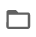
>
> *The 'files' icon*

In [ ]:
!wget http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs

--2021-05-07 18:43:04--  http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs
Resolving openslide.cs.cmu.edu (openslide.cs.cmu.edu)... 128.2.209.93
Connecting to openslide.cs.cmu.edu (openslide.cs.cmu.edu)|128.2.209.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1938955 (1.8M) [image/tiff]
Saving to: ‘CMU-1-Small-Region.svs.1’

CMU-1-Small-Region. 100%[===================>]   1.85M  1.81MB/s    in 1.0s    

2021-05-07 18:43:05 (1.81 MB/s) - ‘CMU-1-Small-Region.svs.1’ saved [1938955/1938955]



# Reading a WSI and its Thumbnail
The toolbox provides a common interface for the many different whole slide image file formats prduced by different vendors. The functions wsireader.get_wsireader takes a file path as input and returns an instance of the appropriate subclass of WSIReader. For more information about WSI reading in tiatoolbox, please refer to the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader) and the [notebook example](https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_wsiread.ipynb) dedicated to this topic.

In [ ]:
wsi = wsireader.get_wsireader(
                input_img='CMU-1-Small-Region.svs')
print(type(wsi))

<class 'tiatoolbox.wsicore.wsireader.OpenSlideWSIReader'>


First, let's check the basic WSI information, such as magnification, dimension, etc. (mpp= microns per pixel).

In [ ]:
wsi_info = wsi.info.as_dict()
# Print one item per line
print(*list(wsi_info.items()), sep='\n')

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', PosixPath('CMU-1-Small-Region.svs'))


Working with `tiatoolbox`, it is easy to load a WSI thumbnail using the `slide_thumbnail` method of the `wsi` object. The thumbnail can be loaded with different resolution units. Following options are available for the `units` argument:

- `mpp`: microns per pixel
- `power`: objective power of the scanner
- `level`: the level in the WSI pyramidal file
- `baseline`: pixels per baseline pixel

We will load (and show) the thumbnail at x1.25 objective power as follows:

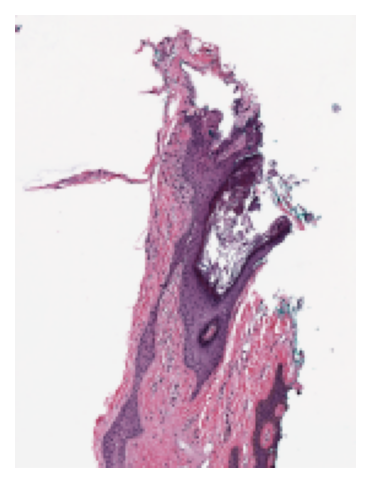

In [ ]:
wsi_thumb = wsi.slide_thumbnail(resolution=1.25, units='power')
plt.imshow(wsi_thumb)
plt.axis('off')
plt.show()

# Generating tissue mask in 1 line of code
The task is to distinguish between tissue and glass (no tissue) in the WSI. We compute a mask, by which we mean a binary colouring of the pixels to either blue=glass or yellow=tissue. Generating the tissue mask for a WSI using tiatoolbox is as simple as the following line of code:

In [ ]:
mask = wsi.tissue_mask(resolution=1.25, units='power')

The output `mask` in the line above is an object from WSIReader class like the `wsi` object itself. It means that you can treat the `mask` just as if it is another slide with the same size of the actual `wsi`.  For example, let's see the thumbnails of the original `wsi` and its `mask` at the same resolution.

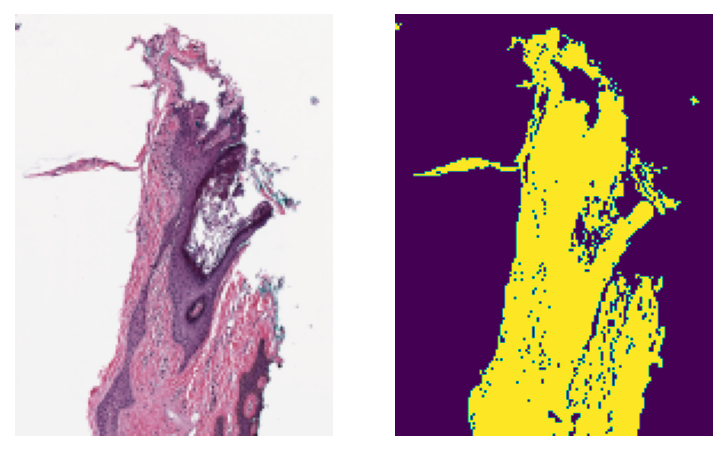

In [ ]:
mask_thumb = mask.slide_thumbnail(resolution=1.25, units='power') #extracting the mask_thumb at the same resolution as wsi_thumb

# showing the result
def show_side_by_side (img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.axis('off')
    plt.show()
show_side_by_side (wsi_thumb, mask_thumb)

As you can see, the generated mask resembles the tissue area of the original WSI pretty well. This kind of mask is usually used in digital pathology pipelines to specify the regions to extract patches from in high resolution. Besides extracting thumbnail, we can also extract regions from the `mask` object as we do for `wsi`:


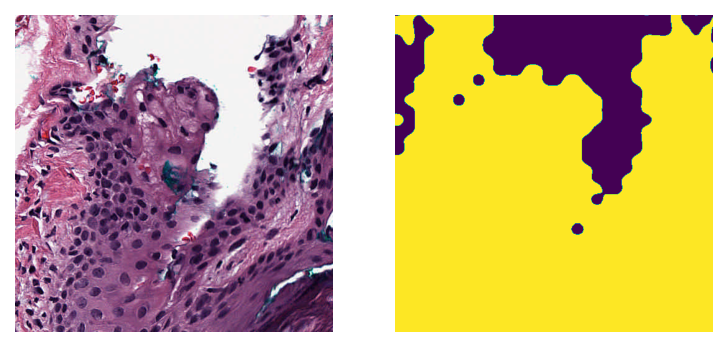

In [ ]:
wsi_region = wsi.read_region(location=(1024, 512), level=0, size=(512, 512))
mask_region = mask.read_region(location=(1024, 512), level=0, size=(512, 512))

show_side_by_side (wsi_region, mask_region)

As expected, the coordinates between the original `wsi` and the `mask` objects line up exactly. This can be particularly useful if you want to calculate statistics of the tissue region in a patch (e.g., tissue area, intensity, and texture information).

Furthermore, there are some options (arguments) that can be used when calling `tissue_mask()` to achieve a more detailed tissue mask in high resolution or to remove small objects from the tissue mask, which will be explained in the next section.


# Generating tissue mask in from images in batch
Utilizing the functionalities in the `tissuemask` tool of the tiatoolbox, we can extract tissue masks for a batch of images in input. In particular, here we use `MorphologicalMasker` to generate the tissue masks for a list of input image regions.

First, we extract two different regions from the `wsi` as our batch of input to be processed (using [`wsi.read_rect`](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=read_rect#tiatoolbox.dataloader.wsireader.WSIReader.read_rect) functionality) and then we instantiate a `MorphologicalMasker` object to be used for extraction of masks from the input batch:

In [ ]:
from tiatoolbox.tools.tissuemask import MorphologicalMasker

# extracting the regions
mag_power = 20 # magnification power to extract patches from and calculate the kernel_size based on
region1 = wsi.read_rect(location=(1024, 256), size=(512, 512), resolution=mag_power, units='power')
region2 = wsi.read_rect(location=(1536, 2048), size=(512, 512), resolution=mag_power, units='power')

# instantiating a MorphologicalMasker
masker = MorphologicalMasker(power=mag_power)

Now, let's apply the `masker` on the extracted patches:

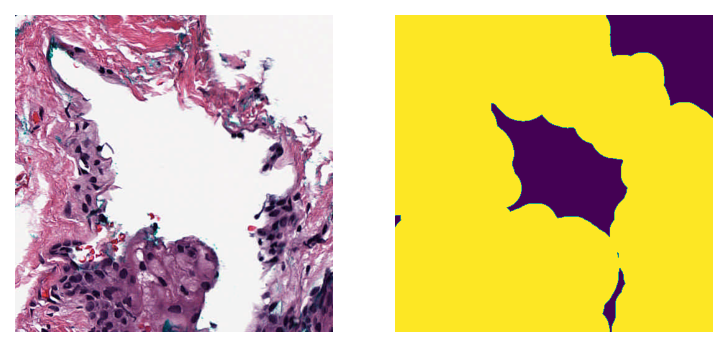

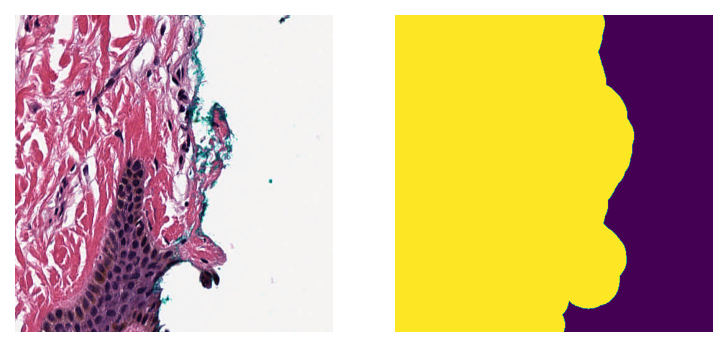

In [ ]:
masks = masker.fit_transform([region1, region2])

# showing the results
show_side_by_side (region1, masks[0])
show_side_by_side (region2, masks[1])

What `fit_transform` does is find the optimal threshold using Otsu's method and then post-process the initial mask by deleting small objects and applying morphological dilation. Due to dilation operation, the detection tissue mask deliberately exceeds the real boundaries of tissues regions because we don't want to miss any tissue information.

You may have noticed that in `fit_transform` function we put the inputs into brackets, i.e. `masker.fit_transform([region1, region2])`. This is because the `fit_transform` function supports batch processing of the input thumbnails. In other words, it accepts a list of RGB images or a numpy array in the expected shape of NxHxWxC (number images, height, width, channels), then the function would output a list of generated tissue masks.


`MorphologicalMasker` can be used with different __optional__ arguments: 

- `kernel_size`: Size of the elliptical kernel to be used for morphological operations in mask post-processing.
- `mpp`: The microns per pixel of the image to be masked. Used to calculate `kernel_size`.
- `power`: The objective power of the image to be masked. Used to calculate `kernel_size`.
- `min_region_size`: Minimum region size in pixels to consider as foreground.

_Please note_ that only one of the `kernel_size`, `mpp`, or `power` argument should be used because only the `kernel_size` is important and used in morphological operations whereas the latter two are used to calculate a suitable `kernel_size`, if not given (the default `kernel_size=1` is used if no argument is given on object instantiating).
More information can be found on [tissuemask](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/tools/tissuemask.py) definition. 


In another example, let's try extracting the mask of `wsi_thumb` using `MorphologicalMasker` and investigate the effect of changing its parameters on the outputs:

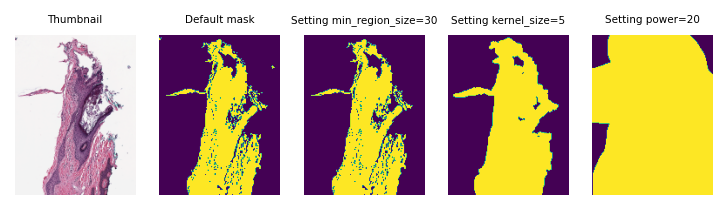

In [ ]:
def make_subplot(img, title, k):
    plt.subplot(1,5,k)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 5})

# default: kernel_size=1, min_region_size=1
masker = MorphologicalMasker() 
masks_default = masker.fit_transform([wsi_thumb])

# kernel_size=1, min_region_size=30
# meaning deleting objects smaller than 30 pixels in area
masker = MorphologicalMasker(min_region_size=30) 
masks_small = masker.fit_transform([wsi_thumb])

# kernel_size=5
# applying morphological dilation with a eleptical kernel (r=5) and
# deleting objects smaller than  pi*5^2 = 78 pixels in area
masker = MorphologicalMasker(kernel_size=5) 
masks_opt = masker.fit_transform([wsi_thumb])

# power=20
# resulting to a over estimated kernel_size, hence bigger mask
masker = MorphologicalMasker(power=20) 
masks_big = masker.fit_transform([wsi_thumb])

# showing the result
make_subplot(wsi_thumb, 'Thumbnail', 1)
make_subplot(masks_default[0], 'Default mask', 2)
make_subplot(masks_small[0], 'Setting min_region_size=30', 3)
make_subplot(masks_opt[0], 'Setting kernel_size=5', 4)
make_subplot(masks_big[0], 'Setting power=20', 5)

plt.show()

As you can see, changing the parameters can change the resulted mask considerably. But don't worry! Normally you don't need to change or set anything when you are working with WSIs in tiatoolbox. Just use the default values of functions and the toolbox tries to find the best parameters for your input WSI (like what we did when we called `mask = wsi.tissue_mask()`). 

Now, feel free to try these functionalities on your data, or change the parameters to see how they can affect the output mask.